<a href="https://colab.research.google.com/github/EAName/yelp-reviews/blob/main/Yelp_NLP_Bag_of_Words_RA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## References
1. Deep Learning with Python, Francois Chollet (https://learning.oreilly.com/library/view/deep-learning-with/9781617296864/)
 * Chapter 10: Deep learning for time series
 * Chapter 11: Deep learning for text
2. Deep Learning A Visual Approach, Andrew Glassner (https://learning.oreilly.com/library/view/deep-learning/9781098129019/)
 * Chapter 19: Recurrent Neural Networks
 * Chapter 20: Attention and Transformers

## Import Packages

In [35]:
from packaging import version

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization


import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import statistics

%matplotlib inline

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, silhouette_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

from sklearn.model_selection import train_test_split

from datetime import datetime


## Verify TensorFlow version and Keras version

In [36]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.9.2


In [37]:
print("Keras version: ", keras.__version__)

Keras version:  2.9.0


## Mount Google Drive to Colab environment

In [38]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Load Reviews Dataset

In [39]:
df =pd.read_csv('/content/gdrive/MyDrive/Data/yelp_reviews_clean_version4_st_louis.csv')

In [40]:
df = df.iloc[:,3:]
df['stars'] = df['stars'].replace([1.0, 2.0, 3.0, 4.0, 5.0], [1, 2, 3, 4, 5])
df['stars'] = df['stars'].astype(int)

In [41]:
train, test = train_test_split(df, test_size=0.7, random_state = 42)

In [42]:
test, val = train_test_split(test, test_size=0.5, random_state = 42)

In [43]:
df2 = train
labels = df2.pop('stars')
train_ds = tf.data.Dataset.from_tensor_slices((df2, labels))
train_ds = train_ds.batch(32)

In [44]:
df2 = test
labels = df2.pop('stars')
test_ds = tf.data.Dataset.from_tensor_slices((df2, labels))
test_ds = test_ds.batch(32)

In [45]:
df2 = val
labels = df2.pop('stars')
val_ds = tf.data.Dataset.from_tensor_slices((df2, labels))
val_ds = val_ds.batch(32)

## Display The Number of Batches

In [46]:
len(train_ds), len(val_ds), len(test_ds)

(2741, 3198, 3198)

In [47]:
len(train), len(val), len(test)

(87712, 102332, 102332)

## Displaying The Shapes and Dtypes of the First Batch

In [48]:
for inputs, targets in train_ds:
    print("inputs.shape:", inputs.shape)
    print()
    print("inputs.dtype:", inputs.dtype)
    print()
    print("targets.shape:", targets.shape)
    print()
    print("targets.dtype:", targets.dtype)
    print()
    print("inputs[0]:", inputs[0])
    print()
    print("targets[0]:", targets[0])
    break

inputs.shape: (32, 1)

inputs.dtype: <dtype: 'string'>

targets.shape: (32,)

targets.dtype: <dtype: 'int64'>

inputs[0]: tf.Tensor([b"i've yet to try the spicy, but it's pretty good chicken, if you're not in the mood for the chain stuff and you want something local."], shape=(1,), dtype=string)

targets[0]: tf.Tensor(3, shape=(), dtype=int64)


In [49]:
def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

In [50]:
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {:.3f}'.format(accuracy_score(test_labels, predictions)))
    print('Mean Absolute Error: {:.3f}'.format(mean_absolute_error(test_labels, predictions)))
    print('Root Mean Square Error: {:.3f}'.format(np.sqrt(MSE(test_labels, predictions))))
    print('Mean Square Error: {:.3f}'.format(MSE(test_labels, predictions, squared = True)))

In [51]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')
    ax.xaxis.set_ticklabels(['1', '2', '3', '4', '5'])
    ax.yaxis.set_ticklabels(['1', '2', '3', '4', '5'])

## Processing words as a set: The bag-of-words approach

The simplest way to encode a piece of text for processing by a machine learning model is to discard order and treat it as a set (a “bag”) of tokens.

## Single words (unigrams) with binary encoding

The main advantage of this encoding is that you can represent an entire text as a single vector, where each entry is a presence indicator for a given word.

## Preprocessing Datasets TextVectorization Layer

<div class="alert alert-block alert-success">
    <b>tf.keras.layers.TextVectorization</b><br>
    https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization
    </div>

In [137]:
text_vectorization = TextVectorization(
    max_tokens=1000,
    output_mode="multi-hot")

In [138]:
text_only_train_ds = train_ds.map(lambda x, y: x)

In [139]:
for text in text_only_train_ds:
    print(f"Get first batch of {text.shape[0]} news articles.\n")
    print(f"Here is the first news article:\n\n{text[0]}.")
    break

Get first batch of 32 news articles.

Here is the first news article:

[b"i've yet to try the spicy, but it's pretty good chicken, if you're not in the mood for the chain stuff and you want something local."].


## Adapt Method - Standardize Text

In [140]:
text_vectorization.adapt(text_only_train_ds)

In [141]:
binary_1gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_1gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_1gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

In [57]:
test_data = [(example.numpy(), label.numpy()) for example, label in binary_1gram_test_ds]
test_y = []

for i in range(len(test)//32):
  for j in range(32):
    test_y.append(test_data[i][1][j])

for j in range(len(test)%32):
  test_y.append(test_data[len(test)//32][1][j])

test_y = np.array(test_y)

In [58]:
test_y.size

102332

## Inspecting Output Binary Unigram Dataset

In [59]:
for inputs, targets in binary_1gram_train_ds:
    print("inputs.shape:", inputs.shape)
    print()
    print("inputs.dtype:", inputs.dtype)
    print()
    print("targets.shape:", targets.shape)
    print()
    print("targets.dtype:", targets.dtype)
    print()
    print("targets[0]:", targets[0])
    break

inputs.shape: (32, 1000)

inputs.dtype: <dtype: 'float32'>

targets.shape: (32,)

targets.dtype: <dtype: 'int64'>

targets[0]: tf.Tensor(3, shape=(), dtype=int64)


# Build Binary Unigram Model

## Model Function 

In [124]:
def get_model(max_tokens=1000, hidden_dim=64):
    inputs = tf.keras.Input(shape=(max_tokens,))
    x = layers.Dense(hidden_dim, activation="relu")(inputs)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(6, activation="softmax")(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer="adam",
                  loss='SparseCategoricalCrossentropy',
                  metrics=["accuracy"])
    return model

In [125]:
model_Unigram = get_model()
model_Unigram.summary()
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("binary_1gram.keras",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 1000)]            0         
                                                                 
 dense_31 (Dense)            (None, 64)                64064     
                                                                 
 dropout_18 (Dropout)        (None, 64)                0         
                                                                 
 dense_32 (Dense)            (None, 6)                 390       
                                                                 
Total params: 64,454
Trainable params: 64,454
Non-trainable params: 0
_________________________________________________________________


In [116]:
history = model_Unigram.fit(binary_1gram_train_ds.cache(),
          validation_data=binary_1gram_val_ds.cache(),
          epochs=20,
          callbacks = callbacks)
model_Unigram = keras.models.load_model("binary_1gram.keras")
print(f"Test acc: {model_Unigram.evaluate(binary_1gram_test_ds)[1]:.3f}")

Epoch 1/20
2741/2741 [==============================] - 20s 7ms/step - loss: 0.9450 - accuracy: 0.5987 - val_loss: 0.8488 - val_accuracy: 0.6345
Epoch 2/20
2741/2741 [==============================] - 12s 4ms/step - loss: 0.8592 - accuracy: 0.6337 - val_loss: 0.8459 - val_accuracy: 0.6350
Epoch 3/20
2741/2741 [==============================] - 12s 4ms/step - loss: 0.8360 - accuracy: 0.6429 - val_loss: 0.8466 - val_accuracy: 0.6338
Epoch 4/20
2741/2741 [==============================] - 12s 4ms/step - loss: 0.8165 - accuracy: 0.6517 - val_loss: 0.8547 - val_accuracy: 0.6338
Epoch 5/20
3198/3198 [==============================] - 9s 3ms/step - loss: 0.8437 - accuracy: 0.6363
Test acc: 0.636


In [117]:
model_Unigram.evaluate(binary_1gram_test_ds)

3198/3198 [==============================] - 10s 3ms/step - loss: 0.8437 - accuracy: 0.6363


[0.8436508178710938, 0.6362819075584412]

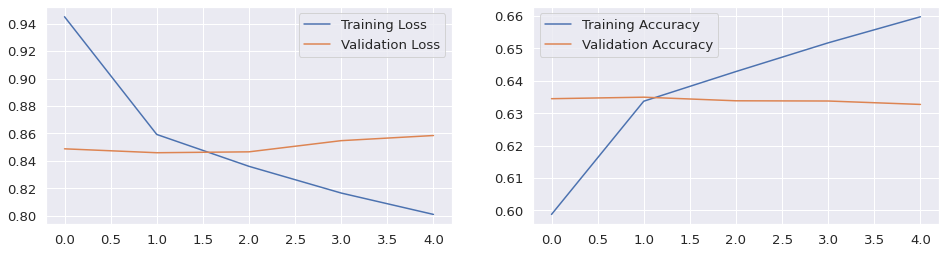

In [118]:
plot_history(history)

In [119]:
pred1= model_Unigram.predict(binary_1gram_test_ds)
pred1=np.argmax(pred1, axis=1)

3198/3198 [==============================] - 6s 2ms/step


In [120]:
print_validation_report(test_y, pred1)

Classification Report
              precision    recall  f1-score   support

           1       0.69      0.73      0.71     11464
           2       0.44      0.34      0.39      9191
           3       0.46      0.39      0.42     12304
           4       0.53      0.45      0.49     25982
           5       0.73      0.86      0.79     43391

    accuracy                           0.64    102332
   macro avg       0.57      0.55      0.56    102332
weighted avg       0.62      0.64      0.62    102332

Accuracy Score: 0.636
Mean Absolute Error: 0.451
Root Mean Square Error: 0.835
Mean Square Error: 0.697


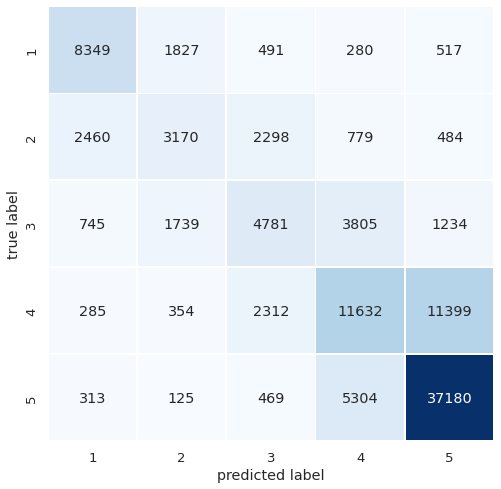

In [121]:
sns.set(font_scale=1.2)
plot_confusion_matrix(test_y,pred1)

## 2 layer model

In [128]:
def get_model(max_tokens=1000, hidden_dim=64):
    inputs = tf.keras.Input(shape=(max_tokens,))
    x = layers.Dense(hidden_dim, activation="relu")(inputs)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(6, activation="softmax")(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer="adam",
                  loss='SparseCategoricalCrossentropy',
                  metrics=["accuracy"])
    return model

### Build Binary Unigram Model

In [129]:
model_Unigram = get_model()
model_Unigram.summary()
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("binary_1gram.keras",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 1000)]            0         
                                                                 
 dense_36 (Dense)            (None, 64)                64064     
                                                                 
 dropout_21 (Dropout)        (None, 64)                0         
                                                                 
 dense_37 (Dense)            (None, 32)                2080      
                                                                 
 dropout_22 (Dropout)        (None, 32)                0         
                                                                 
 dense_38 (Dense)            (None, 6)                 198       
                                                                 
Total params: 66,342
Trainable params: 66,342
Non-trainabl

In [130]:
history = model_Unigram.fit(binary_1gram_train_ds.cache(),
          validation_data=binary_1gram_val_ds.cache(),
          epochs=20,
          callbacks = callbacks)
model_Unigram = keras.models.load_model("binary_1gram.keras")
print(f"Test acc: {model_Unigram.evaluate(binary_1gram_test_ds)[1]:.3f}")

Epoch 1/20
2741/2741 [==============================] - 23s 8ms/step - loss: 1.0613 - accuracy: 0.5528 - val_loss: 0.8687 - val_accuracy: 0.6258
Epoch 2/20
2741/2741 [==============================] - 13s 5ms/step - loss: 0.9230 - accuracy: 0.6097 - val_loss: 0.8567 - val_accuracy: 0.6301
Epoch 3/20
2741/2741 [==============================] - 13s 5ms/step - loss: 0.8974 - accuracy: 0.6207 - val_loss: 0.8542 - val_accuracy: 0.6304
Epoch 4/20
2741/2741 [==============================] - 13s 5ms/step - loss: 0.8805 - accuracy: 0.6236 - val_loss: 0.8548 - val_accuracy: 0.6315
Epoch 5/20
2741/2741 [==============================] - 13s 5ms/step - loss: 0.8690 - accuracy: 0.6296 - val_loss: 0.8551 - val_accuracy: 0.6323
Epoch 6/20
2741/2741 [==============================] - 12s 5ms/step - loss: 0.8615 - accuracy: 0.6336 - val_loss: 0.8572 - val_accuracy: 0.6316
Epoch 7/20
2741/2741 [==============================] - 12s 5ms/step - loss: 0.8487 - accuracy: 0.6393 - val_loss: 0.8590 - val_ac

In [131]:
model_Unigram.evaluate(binary_1gram_test_ds)

3198/3198 [==============================] - 9s 3ms/step - loss: 0.8533 - accuracy: 0.6300


[0.8532889485359192, 0.6299984455108643]

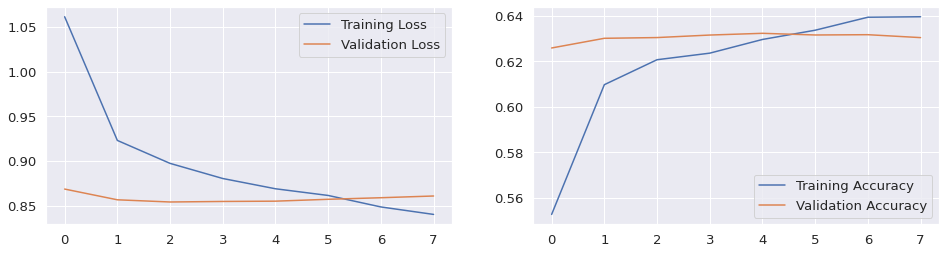

In [132]:
plot_history(history)

In [133]:
pred1= model_Unigram.predict(binary_1gram_test_ds)
pred1=np.argmax(pred1, axis=1)

3198/3198 [==============================] - 8s 3ms/step


In [134]:
print_validation_report(test_y, pred1)

Classification Report
              precision    recall  f1-score   support

           1       0.63      0.79      0.70     11464
           2       0.44      0.31      0.36      9191
           3       0.48      0.31      0.37     12304
           4       0.53      0.41      0.46     25982
           5       0.71      0.88      0.79     43391

    accuracy                           0.63    102332
   macro avg       0.56      0.54      0.54    102332
weighted avg       0.60      0.63      0.61    102332

Accuracy Score: 0.630
Mean Absolute Error: 0.468
Root Mean Square Error: 0.865
Mean Square Error: 0.748


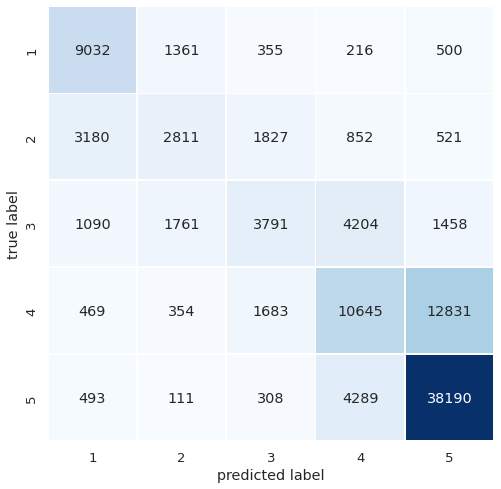

In [135]:
sns.set(font_scale=1.2)
plot_confusion_matrix(test_y,pred1)

We call `cache()` on the datasets to cache them in memory: this way, we will only do the preprocessing once, during the first epoch, and we’ll reuse the preprocessed texts for the following epochs. This can only be done if the data is small enough to fit in memory.

# Build Binary Bigram Model 

In [ ]:
def get_model(max_tokens=1000, hidden_dim=64):
    inputs = tf.keras.Input(shape=(max_tokens,))
    x = layers.Dense(hidden_dim, activation="relu")(inputs)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(6, activation="softmax")(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer="adam",
                  loss='SparseCategoricalCrossentropy',
                  metrics=["accuracy"])
    return model

In [136]:
text_vectorization = TextVectorization(
    ngrams=2,
    max_tokens=1000,
    output_mode="multi_hot",
)

In [69]:
text_vectorization.adapt(text_only_train_ds)
binary_2gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_2gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_2gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

model_Bigram = get_model()
model_Bigram.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dense_4 (Dense)             (None, 32)                32032     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 6)                 198       
                                                                 
Total params: 32,230
Trainable params: 32,230
Non-trainable params: 0
_________________________________________________________________


In [70]:
callbacks = [
     tf.keras.callbacks.ModelCheckpoint("binary_2gram.keras",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]

model_Bigram.fit(binary_2gram_train_ds.cache(),
          validation_data=binary_2gram_val_ds.cache(),
          epochs=20,
          callbacks=callbacks)
model_Bigram = keras.models.load_model("binary_2gram.keras")
print(f"Test acc: {model_Bigram.evaluate(binary_2gram_test_ds)[1]:.3f}")

Epoch 1/20
2741/2741 [==============================] - 21s 7ms/step - loss: 0.9690 - accuracy: 0.5966 - val_loss: 0.8818 - val_accuracy: 0.6269
Epoch 2/20
2741/2741 [==============================] - 13s 5ms/step - loss: 0.9000 - accuracy: 0.6262 - val_loss: 0.8959 - val_accuracy: 0.6288
Epoch 3/20
2741/2741 [==============================] - 13s 5ms/step - loss: 0.8949 - accuracy: 0.6331 - val_loss: 0.9023 - val_accuracy: 0.6266
Epoch 4/20
2741/2741 [==============================] - 14s 5ms/step - loss: 0.8912 - accuracy: 0.6348 - val_loss: 0.9104 - val_accuracy: 0.6255
Epoch 5/20
3198/3198 [==============================] - 9s 3ms/step - loss: 0.8822 - accuracy: 0.6271
Test acc: 0.627


In [71]:
model_Bigram.evaluate(binary_2gram_test_ds)

3198/3198 [==============================] - 9s 3ms/step - loss: 0.8669 - accuracy: 0.6323


[0.8668900728225708, 0.6322948932647705]

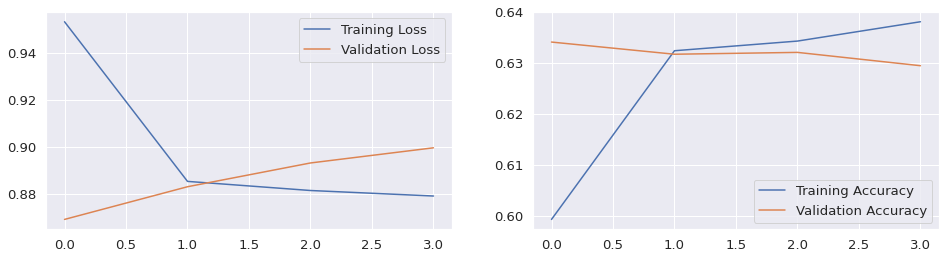

In [72]:
plot_history(history)

In [73]:
pred1= model_Bigram.predict(binary_2gram_test_ds)
pred1=np.argmax(pred1, axis=1)

3198/3198 [==============================] - 6s 2ms/step


In [74]:
print_validation_report(test_y, pred1)

Classification Report
              precision    recall  f1-score   support

           1       0.66      0.75      0.70     11464
           2       0.44      0.34      0.38      9191
           3       0.44      0.41      0.43     12304
           4       0.56      0.39      0.46     25982
           5       0.72      0.87      0.79     43391

    accuracy                           0.63    102332
   macro avg       0.56      0.55      0.55    102332
weighted avg       0.61      0.63      0.61    102332

Accuracy Score: 0.632
Mean Absolute Error: 0.462
Root Mean Square Error: 0.853
Mean Square Error: 0.728


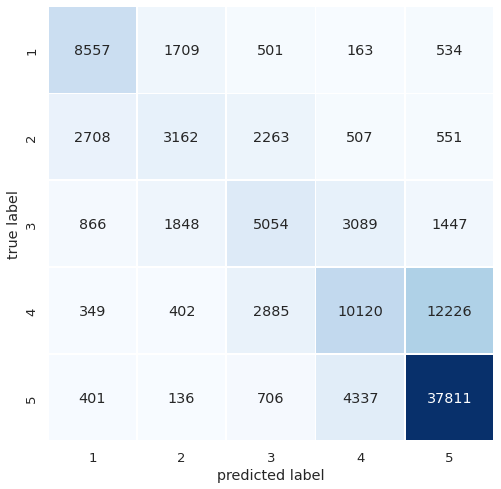

In [75]:
sns.set(font_scale=1.2)
plot_confusion_matrix(test_y,pred1)

## 2 layer model

In [99]:
def get_model(max_tokens=1000, hidden_dim=64):
    inputs = tf.keras.Input(shape=(max_tokens,))
    x = layers.Dense(hidden_dim, activation="relu")(inputs)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(hidden_dim, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(6, activation="softmax")(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer="adam",
                  loss='SparseCategoricalCrossentropy',
                  metrics=["accuracy"])
    return model

In [100]:
model_Bigram = get_model()
model_Bigram.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dense_15 (Dense)            (None, 64)                64064     
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 64)                4160      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 6)                 390       
                                                                 
Total params: 68,614
Trainable params: 68,614
Non-trainable

In [101]:
callbacks = [
     tf.keras.callbacks.ModelCheckpoint("binary_2gram.keras",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]

model_Bigram.fit(binary_2gram_train_ds.cache(),
          validation_data=binary_2gram_val_ds.cache(),
          epochs=20,
          callbacks=callbacks)
model_Bigram = keras.models.load_model("binary_2gram.keras")
print(f"Test acc: {model_Bigram.evaluate(binary_2gram_test_ds)[1]:.3f}")

Epoch 1/20
2741/2741 [==============================] - 20s 7ms/step - loss: 1.0413 - accuracy: 0.5619 - val_loss: 0.8791 - val_accuracy: 0.6194
Epoch 2/20
2741/2741 [==============================] - 13s 5ms/step - loss: 0.9248 - accuracy: 0.6066 - val_loss: 0.8694 - val_accuracy: 0.6261
Epoch 3/20
2741/2741 [==============================] - 13s 5ms/step - loss: 0.9034 - accuracy: 0.6146 - val_loss: 0.8700 - val_accuracy: 0.6241
Epoch 4/20
2741/2741 [==============================] - 12s 5ms/step - loss: 0.8887 - accuracy: 0.6218 - val_loss: 0.8660 - val_accuracy: 0.6284
Epoch 5/20
2741/2741 [==============================] - 13s 5ms/step - loss: 0.8783 - accuracy: 0.6246 - val_loss: 0.8692 - val_accuracy: 0.6264
Epoch 6/20
2741/2741 [==============================] - 14s 5ms/step - loss: 0.8661 - accuracy: 0.6299 - val_loss: 0.8718 - val_accuracy: 0.6264
Epoch 7/20
3198/3198 [==============================] - 9s 3ms/step - loss: 0.8672 - accuracy: 0.6261
Test acc: 0.626


In [ ]:
model_Bigram.evaluate(binary_2gram_test_ds)

3198/3198 [==============================] - 9s 3ms/step - loss: 0.8669 - accuracy: 0.6323


[0.8668900728225708, 0.6322948932647705]

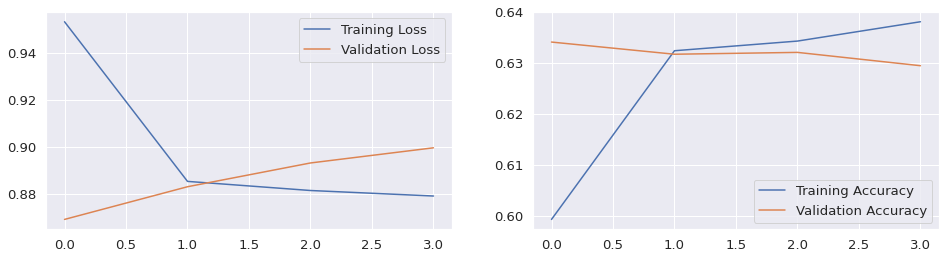

In [ ]:
plot_history(history)

In [ ]:
pred1= model_Bigram.predict(binary_2gram_test_ds)
pred1=np.argmax(pred1, axis=1)

3198/3198 [==============================] - 6s 2ms/step


In [ ]:
print_validation_report(test_y, pred1)

Classification Report
              precision    recall  f1-score   support

           1       0.66      0.75      0.70     11464
           2       0.44      0.34      0.38      9191
           3       0.44      0.41      0.43     12304
           4       0.56      0.39      0.46     25982
           5       0.72      0.87      0.79     43391

    accuracy                           0.63    102332
   macro avg       0.56      0.55      0.55    102332
weighted avg       0.61      0.63      0.61    102332

Accuracy Score: 0.632
Mean Absolute Error: 0.462
Root Mean Square Error: 0.853
Mean Square Error: 0.728


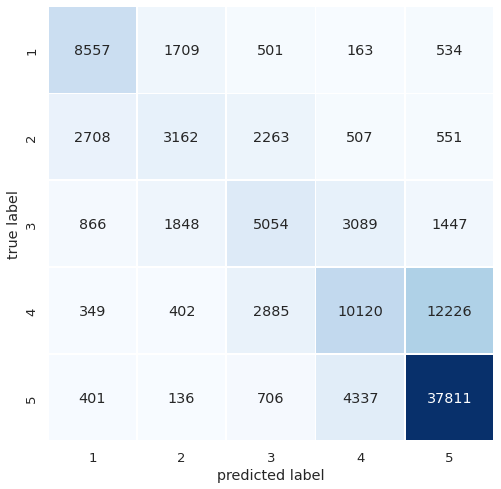

In [ ]:
sns.set(font_scale=1.2)
plot_confusion_matrix(test_y,pred1)

# Count Unigram Model

In [177]:
def get_model(max_tokens=1000, hidden_dim=64):
    inputs = tf.keras.Input(shape=(max_tokens,))
    x = layers.Dense(hidden_dim, activation="relu")(inputs)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(6, activation="softmax")(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer="adam",
                  loss='SparseCategoricalCrossentropy',
                  metrics=["accuracy"])
    return model

In [178]:
text_vectorization = TextVectorization(
    ngrams=1,
    max_tokens=1000,
    output_mode="count",
)

## Build Count Unigram Model 

In [179]:
text_vectorization.adapt(text_only_train_ds)
count_1gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
count_1gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
count_1gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

model_count_Unigram = get_model()
model_count_Unigram.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 1000)]            0         
                                                                 
 dense_49 (Dense)            (None, 64)                64064     
                                                                 
 dropout_29 (Dropout)        (None, 64)                0         
                                                                 
 dense_50 (Dense)            (None, 6)                 390       
                                                                 
Total params: 64,454
Trainable params: 64,454
Non-trainable params: 0
_________________________________________________________________


In [180]:
callbacks = [
     tf.keras.callbacks.ModelCheckpoint("binary_2gram.keras",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]

model_count_Unigram.fit(count_1gram_train_ds.cache(),
          validation_data=count_1gram_val_ds.cache(),
          epochs=20,
          callbacks=callbacks)
model_count_Unigram = keras.models.load_model("binary_2gram.keras")
print(f"Test acc: {model_count_Unigram.evaluate(count_1gram_test_ds)[1]:.3f}")

Epoch 1/20
2741/2741 [==============================] - 19s 7ms/step - loss: 0.9770 - accuracy: 0.5900 - val_loss: 0.8459 - val_accuracy: 0.6377
Epoch 2/20
2741/2741 [==============================] - 12s 4ms/step - loss: 0.8592 - accuracy: 0.6308 - val_loss: 0.8395 - val_accuracy: 0.6391
Epoch 3/20
2741/2741 [==============================] - 12s 4ms/step - loss: 0.8353 - accuracy: 0.6392 - val_loss: 0.8443 - val_accuracy: 0.6370
Epoch 4/20
2741/2741 [==============================] - 12s 4ms/step - loss: 0.8184 - accuracy: 0.6470 - val_loss: 0.8433 - val_accuracy: 0.6387
Epoch 5/20
3198/3198 [==============================] - 10s 3ms/step - loss: 0.8364 - accuracy: 0.6377
Test acc: 0.638


In [181]:
model_count_Unigram.evaluate(count_1gram_test_ds)

3198/3198 [==============================] - 9s 3ms/step - loss: 0.8364 - accuracy: 0.6377


[0.8364471197128296, 0.6377477049827576]

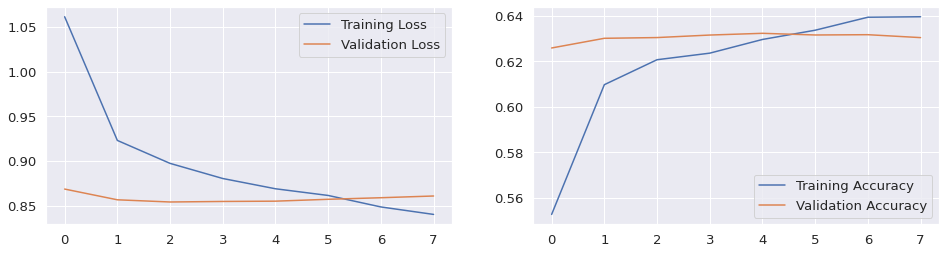

In [182]:
plot_history(history)

In [183]:
pred1= model_count_Unigram.predict(count_1gram_test_ds)
pred1=np.argmax(pred1, axis=1)

3198/3198 [==============================] - 6s 2ms/step


In [184]:
print_validation_report(test_y, pred1)

Classification Report
              precision    recall  f1-score   support

           1       0.67      0.74      0.71     11464
           2       0.45      0.36      0.40      9191
           3       0.47      0.38      0.42     12304
           4       0.55      0.41      0.47     25982
           5       0.72      0.88      0.79     43391

    accuracy                           0.64    102332
   macro avg       0.57      0.55      0.56    102332
weighted avg       0.62      0.64      0.62    102332

Accuracy Score: 0.638
Mean Absolute Error: 0.450
Root Mean Square Error: 0.836
Mean Square Error: 0.699


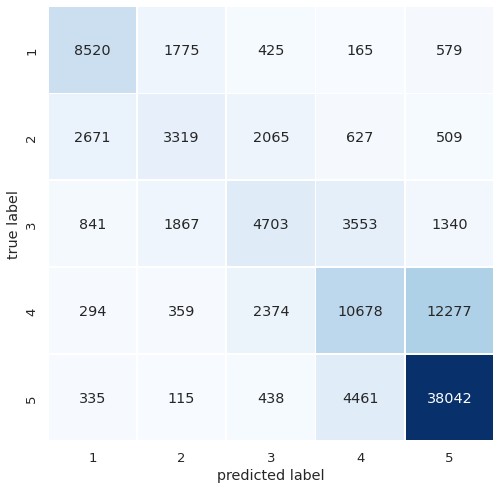

In [185]:
sns.set(font_scale=1.2)
plot_confusion_matrix(test_y,pred1)

## 2 layer model

In [186]:
def get_model(max_tokens=1000, hidden_dim=64):
    inputs = tf.keras.Input(shape=(max_tokens,))
    x = layers.Dense(hidden_dim, activation="relu")(inputs)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(6, activation="softmax")(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer="adam",
                  loss='SparseCategoricalCrossentropy',
                  metrics=["accuracy"])
    return model

In [187]:
model_count_Unigram = get_model()
model_count_Unigram.summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 1000)]            0         
                                                                 
 dense_51 (Dense)            (None, 64)                64064     
                                                                 
 dropout_30 (Dropout)        (None, 64)                0         
                                                                 
 dense_52 (Dense)            (None, 32)                2080      
                                                                 
 dropout_31 (Dropout)        (None, 32)                0         
                                                                 
 dense_53 (Dense)            (None, 6)                 198       
                                                                 
Total params: 66,342
Trainable params: 66,342
Non-trainabl

In [188]:
callbacks = [
     tf.keras.callbacks.ModelCheckpoint("binary_2gram.keras",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]

model_count_Unigram.fit(count_1gram_train_ds.cache(),
          validation_data=count_1gram_val_ds.cache(),
          epochs=20,
          callbacks=callbacks)
model_count_Unigram = keras.models.load_model("binary_2gram.keras")
print(f"Test acc: {model_count_Unigram.evaluate(count_1gram_test_ds)[1]:.3f}")

Epoch 1/20
2741/2741 [==============================] - 16s 6ms/step - loss: 1.1204 - accuracy: 0.5288 - val_loss: 0.8863 - val_accuracy: 0.6252
Epoch 2/20
2741/2741 [==============================] - 12s 5ms/step - loss: 0.9478 - accuracy: 0.6000 - val_loss: 0.8622 - val_accuracy: 0.6291
Epoch 3/20
2741/2741 [==============================] - 13s 5ms/step - loss: 0.9188 - accuracy: 0.6097 - val_loss: 0.8524 - val_accuracy: 0.6343
Epoch 4/20
2741/2741 [==============================] - 12s 5ms/step - loss: 0.9005 - accuracy: 0.6150 - val_loss: 0.8474 - val_accuracy: 0.6353
Epoch 5/20
2741/2741 [==============================] - 12s 5ms/step - loss: 0.8874 - accuracy: 0.6211 - val_loss: 0.8471 - val_accuracy: 0.6365
Epoch 6/20
2741/2741 [==============================] - 14s 5ms/step - loss: 0.8763 - accuracy: 0.6256 - val_loss: 0.8446 - val_accuracy: 0.6361
Epoch 7/20
2741/2741 [==============================] - 12s 5ms/step - loss: 0.8719 - accuracy: 0.6280 - val_loss: 0.8474 - val_ac

In [189]:
model_count_Unigram.evaluate(count_1gram_test_ds)

3198/3198 [==============================] - 9s 3ms/step - loss: 0.8428 - accuracy: 0.6358


[0.8428192138671875, 0.6358323693275452]

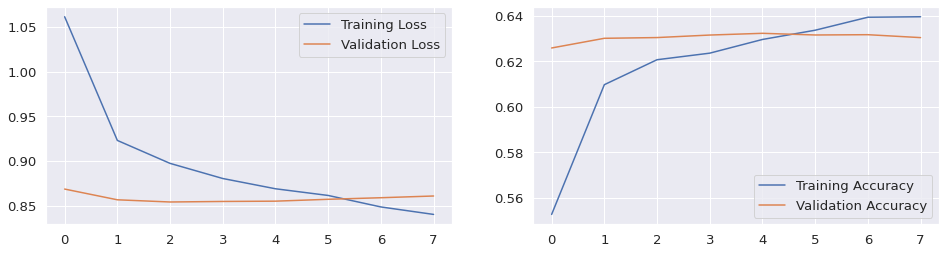

In [190]:
plot_history(history)

In [191]:
pred1= model_count_Unigram.predict(count_1gram_test_ds)
pred1=np.argmax(pred1, axis=1)

3198/3198 [==============================] - 7s 2ms/step


In [192]:
print_validation_report(test_y, pred1)

Classification Report
              precision    recall  f1-score   support

           1       0.67      0.76      0.71     11464
           2       0.42      0.38      0.40      9191
           3       0.50      0.31      0.39     12304
           4       0.53      0.40      0.46     25982
           5       0.72      0.89      0.79     43391

    accuracy                           0.64    102332
   macro avg       0.57      0.55      0.55    102332
weighted avg       0.61      0.64      0.62    102332

Accuracy Score: 0.636
Mean Absolute Error: 0.450
Root Mean Square Error: 0.832
Mean Square Error: 0.693


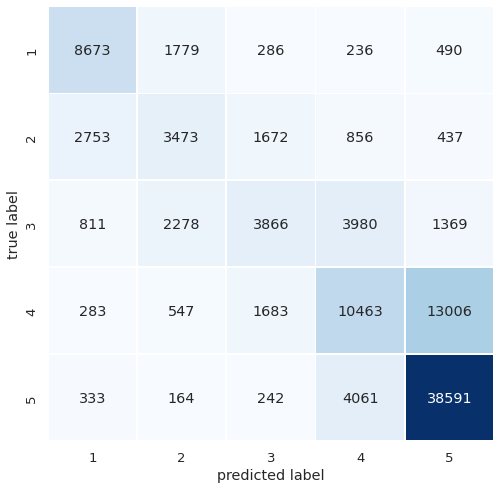

In [193]:
sns.set(font_scale=1.2)
plot_confusion_matrix(test_y,pred1)

# Count Bigram Model

In [155]:
def get_model(max_tokens=1000, hidden_dim=64):
    inputs = tf.keras.Input(shape=(max_tokens,))
    x = layers.Dense(hidden_dim, activation="relu")(inputs)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(6, activation="softmax")(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer="adam",
                  loss='SparseCategoricalCrossentropy',
                  metrics=["accuracy"])
    return model

In [156]:
text_vectorization = TextVectorization(
    ngrams=2,
    max_tokens=1000,
    output_mode="count",
)

## Build Count Bigram Model 

In [157]:
text_vectorization.adapt(text_only_train_ds)
count_2gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
count_2gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
count_2gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

model_count_Bigram = get_model()
model_count_Bigram.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 1000)]            0         
                                                                 
 dense_44 (Dense)            (None, 64)                64064     
                                                                 
 dropout_26 (Dropout)        (None, 64)                0         
                                                                 
 dense_45 (Dense)            (None, 6)                 390       
                                                                 
Total params: 64,454
Trainable params: 64,454
Non-trainable params: 0
_________________________________________________________________


In [158]:
callbacks = [
     tf.keras.callbacks.ModelCheckpoint("binary_2gram.keras",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]

model_count_Bigram.fit(count_2gram_train_ds.cache(),
          validation_data=count_2gram_val_ds.cache(),
          epochs=20,
          callbacks=callbacks)
model_count_Bigram = keras.models.load_model("binary_2gram.keras")
print(f"Test acc: {model_count_Bigram.evaluate(count_2gram_test_ds)[1]:.3f}")

Epoch 1/20
2741/2741 [==============================] - 20s 7ms/step - loss: 1.1114 - accuracy: 0.5665 - val_loss: 0.8815 - val_accuracy: 0.6266
Epoch 2/20
2741/2741 [==============================] - 15s 5ms/step - loss: 0.9110 - accuracy: 0.6118 - val_loss: 0.8621 - val_accuracy: 0.6309
Epoch 3/20
2741/2741 [==============================] - 17s 6ms/step - loss: 0.8902 - accuracy: 0.6179 - val_loss: 0.8580 - val_accuracy: 0.6334
Epoch 4/20
2741/2741 [==============================] - 17s 6ms/step - loss: 0.8767 - accuracy: 0.6246 - val_loss: 0.8708 - val_accuracy: 0.6275
Epoch 5/20
2741/2741 [==============================] - 18s 7ms/step - loss: 0.8656 - accuracy: 0.6274 - val_loss: 0.8605 - val_accuracy: 0.6316
Epoch 6/20
3198/3198 [==============================] - 16s 5ms/step - loss: 0.8585 - accuracy: 0.6322
Test acc: 0.632


In [159]:
model_count_Bigram.evaluate(count_2gram_test_ds)

3198/3198 [==============================] - 10s 3ms/step - loss: 0.8585 - accuracy: 0.6322


[0.8584985136985779, 0.632158100605011]

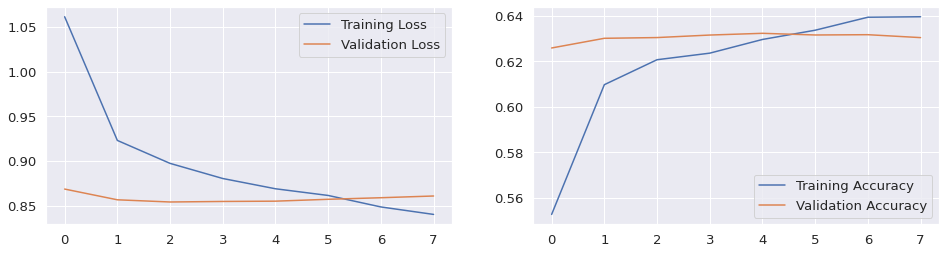

In [160]:
plot_history(history)

In [161]:
pred1= model_count_Bigram.predict(count_2gram_test_ds)
pred1=np.argmax(pred1, axis=1)

3198/3198 [==============================] - 12s 4ms/step


In [162]:
print_validation_report(test_y, pred1)

Classification Report
              precision    recall  f1-score   support

           1       0.66      0.74      0.70     11464
           2       0.43      0.33      0.38      9191
           3       0.47      0.36      0.41     12304
           4       0.54      0.43      0.48     25982
           5       0.72      0.87      0.79     43391

    accuracy                           0.63    102332
   macro avg       0.56      0.55      0.55    102332
weighted avg       0.61      0.63      0.62    102332

Accuracy Score: 0.632
Mean Absolute Error: 0.469
Root Mean Square Error: 0.875
Mean Square Error: 0.766


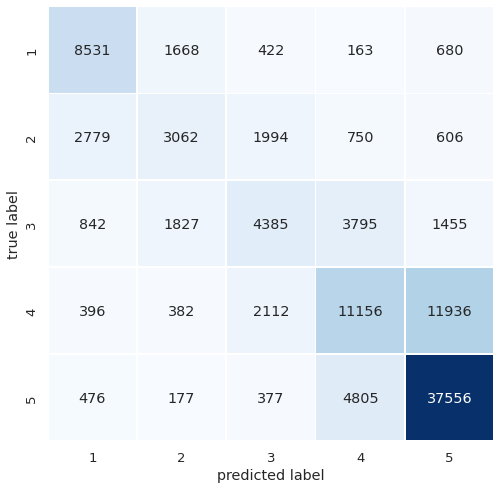

In [163]:
sns.set(font_scale=1.2)
plot_confusion_matrix(test_y,pred1)

## 2 layer model

In [164]:
def get_model(max_tokens=1000, hidden_dim=64):
    inputs = tf.keras.Input(shape=(max_tokens,))
    x = layers.Dense(hidden_dim, activation="relu")(inputs)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(6, activation="softmax")(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer="adam",
                  loss='SparseCategoricalCrossentropy',
                  metrics=["accuracy"])
    return model

In [165]:
model_count_Bigram = get_model()
model_count_Bigram.summary()

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 1000)]            0         
                                                                 
 dense_46 (Dense)            (None, 64)                64064     
                                                                 
 dropout_27 (Dropout)        (None, 64)                0         
                                                                 
 dense_47 (Dense)            (None, 32)                2080      
                                                                 
 dropout_28 (Dropout)        (None, 32)                0         
                                                                 
 dense_48 (Dense)            (None, 6)                 198       
                                                                 
Total params: 66,342
Trainable params: 66,342
Non-trainabl

In [166]:
callbacks = [
     tf.keras.callbacks.ModelCheckpoint("binary_2gram.keras",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]

model_count_Bigram.fit(count_2gram_train_ds.cache(),
          validation_data=count_2gram_val_ds.cache(),
          epochs=20,
          callbacks=callbacks)
model_count_Bigram = keras.models.load_model("binary_2gram.keras")
print(f"Test acc: {model_count_Bigram.evaluate(count_2gram_test_ds)[1]:.3f}")

Epoch 1/20
2741/2741 [==============================] - 22s 8ms/step - loss: 1.2139 - accuracy: 0.5034 - val_loss: 0.9235 - val_accuracy: 0.6132
Epoch 2/20
2741/2741 [==============================] - 12s 5ms/step - loss: 0.9983 - accuracy: 0.5708 - val_loss: 0.8849 - val_accuracy: 0.6222
Epoch 3/20
2741/2741 [==============================] - 12s 5ms/step - loss: 0.9636 - accuracy: 0.5900 - val_loss: 0.8768 - val_accuracy: 0.6212
Epoch 4/20
2741/2741 [==============================] - 12s 5ms/step - loss: 0.9465 - accuracy: 0.5936 - val_loss: 0.8768 - val_accuracy: 0.6214
Epoch 5/20
2741/2741 [==============================] - 13s 5ms/step - loss: 0.9355 - accuracy: 0.6013 - val_loss: 0.8775 - val_accuracy: 0.6231
Epoch 6/20
2741/2741 [==============================] - 14s 5ms/step - loss: 0.9270 - accuracy: 0.6024 - val_loss: 0.8650 - val_accuracy: 0.6290
Epoch 7/20
2741/2741 [==============================] - 13s 5ms/step - loss: 0.9197 - accuracy: 0.6078 - val_loss: 0.8752 - val_ac

In [172]:
model_count_Bigram.evaluate(count_2gram_test_ds)

3198/3198 [==============================] - 9s 3ms/step - loss: 0.8668 - accuracy: 0.6267


[0.866754949092865, 0.6266856789588928]

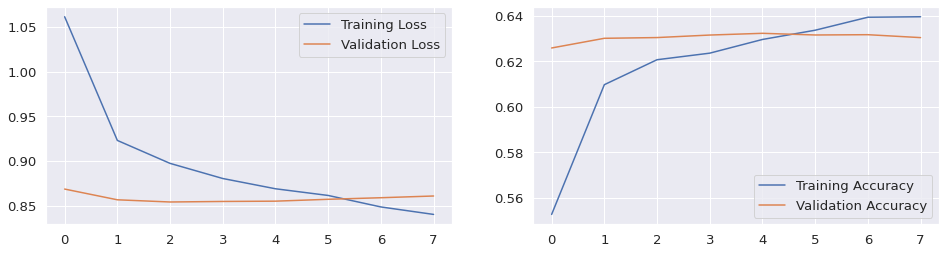

In [173]:
plot_history(history)

In [174]:
pred1= model_count_Bigram.predict(count_2gram_test_ds)
pred1=np.argmax(pred1, axis=1)

3198/3198 [==============================] - 8s 2ms/step


In [175]:
print_validation_report(test_y, pred1)

Classification Report
              precision    recall  f1-score   support

           1       0.60      0.82      0.69     11464
           2       0.43      0.20      0.27      9191
           3       0.47      0.37      0.42     12304
           4       0.53      0.37      0.44     25982
           5       0.71      0.89      0.79     43391

    accuracy                           0.63    102332
   macro avg       0.55      0.53      0.52    102332
weighted avg       0.60      0.63      0.60    102332

Accuracy Score: 0.627
Mean Absolute Error: 0.481
Root Mean Square Error: 0.891
Mean Square Error: 0.794


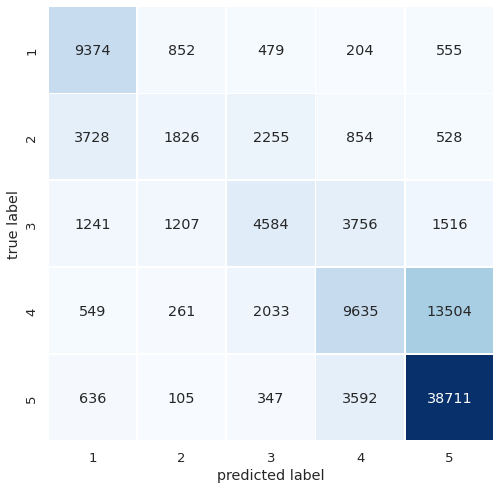

In [176]:
sns.set(font_scale=1.2)
plot_confusion_matrix(test_y,pred1)

# Bigrams with TF-IDF Encoding

You can also add a bit more information to this representation by counting how many times each word or N-gram occurs, that is to say, by taking the histogram of the words over the text:

```{"the": 2, "the cat": 1, "cat": 1, "cat sat": 1, "sat": 1,
 "sat on": 1, "on": 1, "on the": 1, "the mat: 1", "mat": 1}```

## Understanding TF-IDF normalization
The more a given term appears in a document, the more important that term is for understanding what the document is about. At the same time, the frequency at which the term appears across all documents in your dataset matters too: terms that appear in almost every document (like “the” or “a”) aren’t particularly informative,

`TF-IDF` is a metric that fuses these two ideas. It weights a given term by taking “term frequency,” how many times the term appears in the current document, and dividing it by a measure of “document frequency,” which estimates how often the term comes up across the dataset. 

## Configuring `TextVectorization` To Return TF-IDF-weighted Outputs

In [194]:
text_vectorization = TextVectorization(
    ngrams=2,
    max_tokens=1000,
    output_mode="tf_idf",
)

## Build TF-IDF Bigram Model

In [200]:
def get_model(max_tokens=1000, hidden_dim=64):
    inputs = tf.keras.Input(shape=(max_tokens,))
    x = layers.Dense(hidden_dim, activation="relu")(inputs)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(6, activation="softmax")(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer="adam",
                  loss='SparseCategoricalCrossentropy',
                  metrics=["accuracy"])
    return model

In [195]:
text_vectorization.adapt(text_only_train_ds)

tfidf_2gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
tfidf_2gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
tfidf_2gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 1000)]            0         
                                                                 
 dense_54 (Dense)            (None, 64)                64064     
                                                                 
 dropout_32 (Dropout)        (None, 64)                0         
                                                                 
 dense_55 (Dense)            (None, 32)                2080      
                                                                 
 dropout_33 (Dropout)        (None, 32)                0         
                                                                 
 dense_56 (Dense)            (None, 6)                 198       
                                                                 
Total params: 66,342
Trainable params: 66,342
Non-trainabl

In [201]:
model_tfidf = get_model()
model_tfidf.summary()

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 1000)]            0         
                                                                 
 dense_60 (Dense)            (None, 64)                64064     
                                                                 
 dropout_36 (Dropout)        (None, 64)                0         
                                                                 
 dense_61 (Dense)            (None, 6)                 390       
                                                                 
Total params: 64,454
Trainable params: 64,454
Non-trainable params: 0
_________________________________________________________________


In [202]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("tfidf_2gram.keras",save_best_only=True)
   ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]

model_tfidf.fit(tfidf_2gram_train_ds.cache(),
          validation_data=tfidf_2gram_val_ds.cache(),
          epochs=20,
          callbacks=callbacks)
model_tfidf = keras.models.load_model("tfidf_2gram.keras")
print(f"Test acc: {model_tfidf.evaluate(tfidf_2gram_test_ds)[1]:.3f}")

Epoch 1/20
2741/2741 [==============================] - 16s 6ms/step - loss: 1.3355 - accuracy: 0.5305 - val_loss: 0.9015 - val_accuracy: 0.6182
Epoch 2/20
2741/2741 [==============================] - 17s 6ms/step - loss: 0.9668 - accuracy: 0.5870 - val_loss: 0.8740 - val_accuracy: 0.6270
Epoch 3/20
2741/2741 [==============================] - 12s 4ms/step - loss: 0.9379 - accuracy: 0.5945 - val_loss: 0.8792 - val_accuracy: 0.6277
Epoch 4/20
2741/2741 [==============================] - 12s 4ms/step - loss: 0.9223 - accuracy: 0.5991 - val_loss: 0.8772 - val_accuracy: 0.6266
Epoch 5/20
2741/2741 [==============================] - 12s 4ms/step - loss: 0.9113 - accuracy: 0.6039 - val_loss: 0.8751 - val_accuracy: 0.6306
Epoch 6/20
2741/2741 [==============================] - 12s 4ms/step - loss: 0.9027 - accuracy: 0.6074 - val_loss: 0.8773 - val_accuracy: 0.6279
Epoch 7/20
2741/2741 [==============================] - 12s 4ms/step - loss: 0.8969 - accuracy: 0.6089 - val_loss: 0.8700 - val_ac

In [203]:
model_tfidf.evaluate(tfidf_2gram_test_ds)

3198/3198 [==============================] - 9s 3ms/step - loss: 0.8718 - accuracy: 0.6276


[0.8717953562736511, 0.62758469581604]

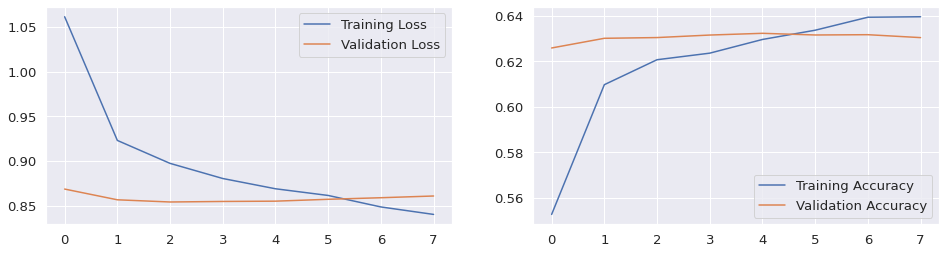

In [204]:
plot_history(history)

In [205]:
pred1= model_tfidf.predict(tfidf_2gram_test_ds)
pred1=np.argmax(pred1, axis=1)

3198/3198 [==============================] - 7s 2ms/step


In [206]:
print_validation_report(test_y, pred1)

Classification Report
              precision    recall  f1-score   support

           1       0.66      0.72      0.69     11464
           2       0.44      0.31      0.36      9191
           3       0.49      0.32      0.39     12304
           4       0.52      0.43      0.47     25982
           5       0.71      0.88      0.78     43391

    accuracy                           0.63    102332
   macro avg       0.56      0.53      0.54    102332
weighted avg       0.60      0.63      0.61    102332

Accuracy Score: 0.628
Mean Absolute Error: 0.481
Root Mean Square Error: 0.895
Mean Square Error: 0.800


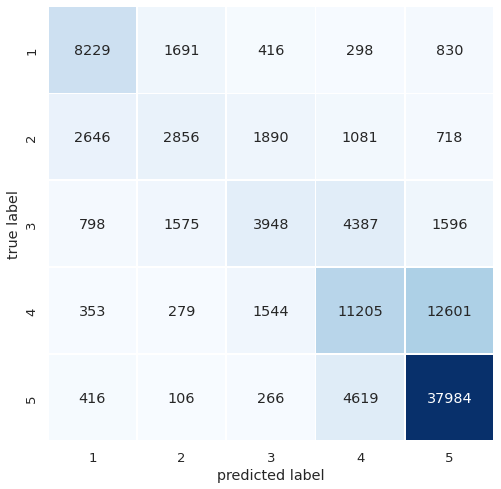

In [207]:
sns.set(font_scale=1.2)
plot_confusion_matrix(test_y,pred1)

## 2 layer model

In [208]:
def get_model(max_tokens=1000, hidden_dim=64):
    inputs = tf.keras.Input(shape=(max_tokens,))
    x = layers.Dense(hidden_dim, activation="relu")(inputs)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(6, activation="softmax")(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer="adam",
                  loss='SparseCategoricalCrossentropy',
                  metrics=["accuracy"])
    return model

In [209]:
model_tfidf = get_model()
model_tfidf.summary()

Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 1000)]            0         
                                                                 
 dense_62 (Dense)            (None, 64)                64064     
                                                                 
 dropout_37 (Dropout)        (None, 64)                0         
                                                                 
 dense_63 (Dense)            (None, 32)                2080      
                                                                 
 dropout_38 (Dropout)        (None, 32)                0         
                                                                 
 dense_64 (Dense)            (None, 6)                 198       
                                                                 
Total params: 66,342
Trainable params: 66,342
Non-trainabl

In [210]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("tfidf_2gram.keras",save_best_only=True)
   ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]

model_tfidf.fit(tfidf_2gram_train_ds.cache(),
          validation_data=tfidf_2gram_val_ds.cache(),
          epochs=20,
          callbacks=callbacks)
model_tfidf = keras.models.load_model("tfidf_2gram.keras")
print(f"Test acc: {model_tfidf.evaluate(tfidf_2gram_test_ds)[1]:.3f}")

Epoch 1/20
2741/2741 [==============================] - 22s 8ms/step - loss: 1.4782 - accuracy: 0.4638 - val_loss: 0.9699 - val_accuracy: 0.5892
Epoch 2/20
2741/2741 [==============================] - 13s 5ms/step - loss: 1.0711 - accuracy: 0.5428 - val_loss: 0.9390 - val_accuracy: 0.5908
Epoch 3/20
2741/2741 [==============================] - 12s 5ms/step - loss: 1.0214 - accuracy: 0.5612 - val_loss: 0.9168 - val_accuracy: 0.6057
Epoch 4/20
2741/2741 [==============================] - 12s 5ms/step - loss: 0.9969 - accuracy: 0.5701 - val_loss: 0.9117 - val_accuracy: 0.6048
Epoch 5/20
2741/2741 [==============================] - 13s 5ms/step - loss: 0.9785 - accuracy: 0.5780 - val_loss: 0.8990 - val_accuracy: 0.6101
Epoch 6/20
2741/2741 [==============================] - 12s 5ms/step - loss: 0.9676 - accuracy: 0.5838 - val_loss: 0.8958 - val_accuracy: 0.6091
Epoch 7/20
2741/2741 [==============================] - 12s 5ms/step - loss: 0.9617 - accuracy: 0.5877 - val_loss: 0.8941 - val_ac

In [211]:
model_tfidf.evaluate(tfidf_2gram_test_ds)

3198/3198 [==============================] - 9s 3ms/step - loss: 0.8786 - accuracy: 0.6212


[0.878635048866272, 0.6211546659469604]

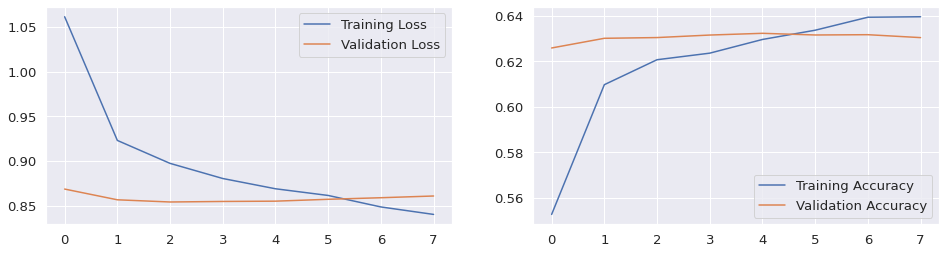

In [212]:
plot_history(history)

In [213]:
pred1= model_tfidf.predict(tfidf_2gram_test_ds)
pred1=np.argmax(pred1, axis=1)

3198/3198 [==============================] - 7s 2ms/step


In [214]:
print_validation_report(test_y, pred1)

Classification Report
              precision    recall  f1-score   support

           1       0.59      0.83      0.69     11464
           2       0.44      0.11      0.17      9191
           3       0.43      0.36      0.40     12304
           4       0.52      0.39      0.44     25982
           5       0.71      0.89      0.79     43391

    accuracy                           0.62    102332
   macro avg       0.54      0.51      0.50    102332
weighted avg       0.59      0.62      0.59    102332

Accuracy Score: 0.621
Mean Absolute Error: 0.487
Root Mean Square Error: 0.892
Mean Square Error: 0.795


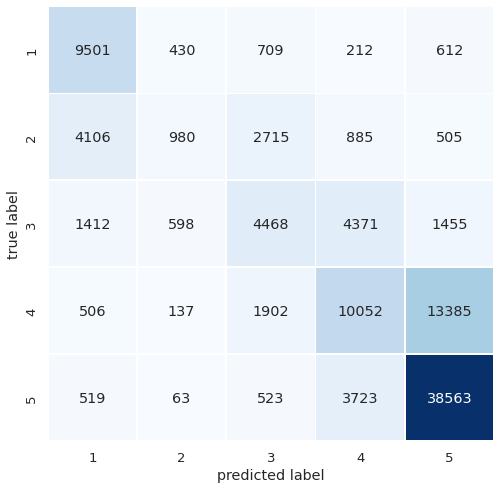

In [215]:
sns.set(font_scale=1.2)
plot_confusion_matrix(test_y,pred1)